In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, TimeDistributed, Dense

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report

pd.set_option('display.max_rows', 3000)
# pd.reset_option('display.max_rows')

-----

## Some exploration

In [3]:
data_path = "../conll2003/"

train_raw = pd.read_csv(data_path + "eng.train", sep=" ", header=None, usecols=[0,3], skip_blank_lines=False)
train_raw.fillna("", inplace=True)
train_raw.columns = ["word", "tag"]

# Remove first line
train_raw = train_raw[train_raw.word != "-DOCSTART-"]

In [4]:
# Show label distribution
train_raw.groupby('tag').count()

,word
tag,
,17165
B-LOC,11
B-MISC,37
B-ORG,24
I-LOC,8286
I-MISC,4556
I-ORG,10001
I-PER,11128
O,167400


In [5]:
train_raw[train_raw.tag == 'B-ORG'].head()

,word,tag
144803,SPD,B-ORG
144804,FDP,B-ORG
144805,Greens,B-ORG
144806,PDS,B-ORG
144850,SPD,B-ORG


In [6]:
train_raw.loc[144797:144807]

,word,tag
144797,,
144798,AUGUST,O
144799,1996,O
144800,CDU,I-ORG
144801,/,I-ORG
144802,CSU,I-ORG
144803,SPD,B-ORG
144804,FDP,B-ORG
144805,Greens,B-ORG
144806,PDS,B-ORG


In [7]:
train_raw[train_raw.tag == 'B-MISC'].head()

,word,tag
3453,MiG-19,B-MISC
6845,County,B-MISC
8895,Davis,B-MISC
18089,CNB-120,B-MISC
22934,Roman,B-MISC


In [8]:
train_raw.loc[6840:6850]

,word,tag
6840,scores,O
6841,in,O
6842,four-day,O
6843,,
6844,English,I-MISC
6845,County,B-MISC
6846,Championship,I-MISC
6847,cricket,O
6848,matches,O
6849,on,O


In [9]:
train_raw[train_raw.tag == 'B-LOC'].head()

,word,tag
1946,Israel,B-LOC
137231,MT,B-LOC
137242,MT,B-LOC
137252,MT,B-LOC
137263,MT,B-LOC


In [10]:
train_raw.loc[137225:137270]

,word,tag
137225,12pct,O
137226,Chg,O
137227,White,O
137228,Chg,O
137229,,
137230,Billings,I-LOC
137231,MT,B-LOC
137232,4.62,O
137233,up,O
137234,.01,O


### Observations:
* Small set of "real" NER tags which leads to a heavy imbalance between the "O" tag and the rest

* The "B-" labels will probably be hard to predict because of the extreme imbalance of occurences
* That's because "B-" labels are only needed in very specific curcumstances, at least in this dataset, e.g.
    * lists of political parties
    * mentioning a city name from the USA where it's common to provide the state information as well
    * Names of prices or tournaments like "Australien Davis Cup" or "English County Championship", where one could also question the tagging anyway. 
    
    
### Conclusions
* Performance for "B-"s will probably be abysmal. But this will be ignored for now since we don't care about those in particular for now
* Imbalance might be a problem, but we'll try how far we can get without dealing with it

----

## Loading the data

In [11]:
data_path = "../conll2003/"

unique_labels = []

sentences = []
ner_tags = []

sentence = []
tag_sequence = []

for line in open(data_path + "eng.train", 'r'):
    line = line.strip()
    if not line.startswith('-DOCSTART-'):
        if line != '':
            parts = line.split(' ')
            sentence.append(parts[0])
            tag_sequence.append(parts[3])
            if parts[3] not in unique_labels:
                unique_labels.append(parts[3])
        else:
            if len(sentence) != 0:
                sentences.append(sentence)
                ner_tags.append(tag_sequence)
            sentence = []
            tag_sequence = []


#### Check out sentence length

Max sentences length: 113


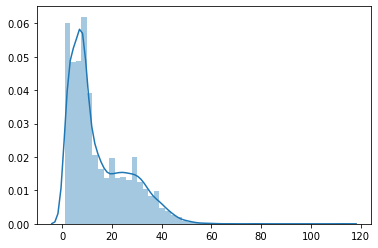

In [12]:
sentence_lengths = [len(s) for s in sentences]
sns.distplot(sentence_lengths)
print(f"Max sentences length: {max(sentence_lengths)}")

----

## Preprocessing

* Tokenization (lower-casing included)
* Padding to the max-length of all sentences

We're targeting a sentence-based input. Therefore the target result vectors will be the following:
* X: Array of sequences. One sequence is a complete sentence from the training data.
* y: Array of sequences. One sequence is a the list of NER labels for all the words in an input sequence in X. 

In [13]:
# Tokenizer for the sentences
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
input_sequences = tokenizer.texts_to_sequences(sentences)
padded_input_sequences = np.array(pad_sequences(input_sequences, padding='post'))


# Tokenizer for the labels
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(ner_tags)
label_sequences = label_tokenizer.texts_to_sequences(ner_tags)
padded_label_sequences = np.array(pad_sequences(label_sequences, padding='post'))


# Some useful stats
unique_words = len(tokenizer.word_index) + 1 # +1 for padding token
max_sequence_length= max([len(seq) for seq in input_sequences])
unique_tags = len(label_tokenizer.word_index)

In [14]:
padded_input_sequences

array([[  989, 10951,   205, ...,     0,     0,     0],
       [  774,  1872,     0, ...,     0,     0,     0],
       [  726,   150,     0, ...,     0,     0,     0],
       ...,
       [ 3094,    21,  2147, ...,     0,     0,     0],
       [   89,    85,     0, ...,     0,     0,     0],
       [ 4384,    17,  2535, ...,     0,     0,     0]])

In [15]:
padded_label_sequences

array([[3, 1, 5, ..., 0, 0, 0],
       [2, 2, 0, ..., 0, 0, 0],
       [4, 1, 0, ..., 0, 0, 0],
       ...,
       [3, 1, 3, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [3, 1, 3, ..., 0, 0, 0]])

In [16]:
label_tokenizer.index_word

{1: 'o',
 2: 'i-per',
 3: 'i-org',
 4: 'i-loc',
 5: 'i-misc',
 6: 'b-misc',
 7: 'b-org',
 8: 'b-loc'}

---------

## Model Training

In [18]:
embedding_size = 300

model = tf.keras.models.Sequential([
    Embedding(unique_words, embedding_size, input_length=max_sequence_length, mask_zero=True),
    Bidirectional(LSTM(150, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)),
    TimeDistributed(Dense(unique_tags + 1, activation='softmax'))
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 113, 300)          6303300   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 113, 300)          541200    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 113, 9)            2709      
Total params: 6,847,209
Trainable params: 6,847,209
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(padded_input_sequences, padded_label_sequences, batch_size=30, epochs=10, verbose=1)

Epoch 1/10
469/469 [==============================] - 786s 2s/step - loss: 0.0490 - accuracy: 0.1169
Epoch 2/10
469/469 [==============================] - 922s 2s/step - loss: 0.0112 - accuracy: 0.1251
Epoch 3/10
469/469 [==============================] - 784s 2s/step - loss: 0.0061 - accuracy: 0.1265
Epoch 4/10
469/469 [==============================] - 772s 2s/step - loss: 0.0042 - accuracy: 0.1270
Epoch 5/10
469/469 [==============================] - 779s 2s/step - loss: 0.0030 - accuracy: 0.1274
Epoch 6/10
469/469 [==============================] - 784s 2s/step - loss: 0.0022 - accuracy: 0.1276
Epoch 7/10
469/469 [==============================] - 793s 2s/step - loss: 0.0016 - accuracy: 0.1278
Epoch 8/10
469/469 [==============================] - 783s 2s/step - loss: 0.0013 - accuracy: 0.1279
Epoch 9/10
469/469 [==============================] - 764s 2s/step - loss: 9.4798e-04 - accuracy: 0.1281
Epoch 10/10
469/469 [==============================] - 766s 2s/step - loss: 8.4766e-04 

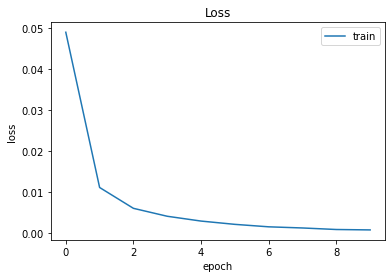

In [36]:
plt.plot(history.history['loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [25]:
model_path = './models'
model.save(f"{model_path}/my_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/my_model\assets


---------

## Validation

### Load and Transform validation data

In [37]:
# Loading validation data

val_sentences = []
val_ner_tags = []

val_sentence = []
val_tag_sequence = []

for line in open(data_path + "eng.testb", 'r'):
    line = line.strip()
    if not line.startswith('-DOCSTART-'):
        if line != '':
            parts = line.split(' ')
            val_sentence.append(parts[0])
            val_tag_sequence.append(parts[3])
        else:
            if len(val_sentence) != 0:
                val_sentences.append(val_sentence)
                val_ner_tags.append(val_tag_sequence)
            val_sentence = []
            val_tag_sequence = []
            

# Using the tokenizers (which was fitted on the training data) + pad to input length
val_input_sequences = tokenizer.texts_to_sequences(val_sentences)
val_padded_input_sequences = np.array(pad_sequences(val_input_sequences, padding='post', maxlen=max_sequence_length))


val_label_sequences = label_tokenizer.texts_to_sequences(val_ner_tags)
val_padded_label_sequences = np.array(pad_sequences(val_label_sequences, padding='post', maxlen=max_sequence_length))

### Predict and evaluate for each class

In [24]:
pred = model.predict(val_padded_input_sequences)
pred = pred.argmax(axis=-1)

y_true = val_padded_label_sequences.flatten()
y_hat = pred.flatten()

y_true_mapped = np.vectorize(label_tokenizer.index_word.get)(y_true)
y_hat_mapped = np.vectorize(label_tokenizer.index_word.get)(y_hat)

print(classification_report(y_true_mapped, y_hat_mapped))

C:\Users\mbergman\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        None       0.00      0.00      0.00    343765
       b-loc       0.00      0.00      0.00         6
      b-misc       0.00      0.00      0.00         9
       b-org       0.00      0.00      0.00         5
       i-loc       0.78      0.82      0.80      1918
      i-misc       0.76      0.69      0.72       909
       i-org       0.78      0.65      0.71      2490
       i-per       0.91      0.71      0.80      2771
           o       0.10      0.98      0.18     38316

    accuracy                           0.11    390189
   macro avg       0.37      0.43      0.36    390189
weighted avg       0.03      0.11      0.03    390189



#### Observations:
* The performance for the "B-" tags couldn't be worse, as expected.
* Precision for "O" tag is very low due to the imbalanced dataset. 
* F1s for the other labels are quite good for the rather simple approach

#### Things to try next:
* Ading a CRF layer might help with the overall performance and possibly for "B-" tags
* Dealing with the imbalance of "O" tags might improve the overall performance
* The average sentence length is way below the max. In fact there are a lot of short text snippets that barely count as sentence. So trying different input transformations might be a good idea
* Also, it's unclear how the padding affects the model. Padding tokens are ignored, but it needs to be investigated what that means for the computation and what the effect performance-wise
* Try different architectures and tune hyperparameters

### Inspecting some of the predicted values

In [26]:
df = pd.DataFrame(
    {
        "word": val_padded_input_sequences.flatten(),
        "true": val_padded_label_sequences.flatten(),
        "pred": pred.flatten()
    })


def token_to_word(token):
    if token != 0:
        return tokenizer.index_word[token]
    else: 
        return ''
    
def label_token_to_word(token):
    if token != 0:
        return label_tokenizer.index_word[token]
    else: 
        return ''

df.word = df.word.apply(token_to_word)
df.true = df.true.apply(label_token_to_word)
df.pred = df.pred.apply(label_token_to_word)

In [39]:
# Remove empty rows and show those that have a label other than 'O' (limit 100)

df[(df.word != '') & (df.true != 'o')].iloc[:100]

,word,true,pred
2,japan,i-loc,i-loc
7,china,i-per,i-loc
113,<OOV>,i-per,o
114,<OOV>,i-per,o
226,<OOV>,i-loc,o
228,united,i-loc,i-loc
229,arab,i-loc,i-loc
230,emirates,i-loc,i-loc
339,japan,i-loc,i-loc
345,asian,i-misc,i-misc
